In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.9 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Input, MaxPooling2D
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint
import plotly.express as px
from numpy import expand_dims
from keras.applications import MobileNet

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/Kompjuterski vid/Projekat/dataset1/sign_mnist_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Kompjuterski vid/Projekat/dataset1/sign_mnist_test.csv")

In [5]:
test = pd.read_csv("/content/drive/MyDrive/Kompjuterski vid/Projekat/dataset1/sign_mnist_test.csv")
y = test['label']

In [6]:
labele = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

In [7]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [9]:
x_train = train_df.values
x_test = test_df.values

In [10]:
x_train_rgb_pom = x_train.reshape(-1,28,28,1)
x_test_rgb_pom = x_test.reshape(-1,28,28,1)

images = tf.convert_to_tensor(x_train_rgb_pom, dtype=tf.uint8)
x_train = tf.image.grayscale_to_rgb(images,name=None)

images1 = tf.convert_to_tensor(x_test_rgb_pom, dtype=tf.uint8)
x_test = tf.image.grayscale_to_rgb(images1,name=None)

In [11]:
def plot_loss_accuracy(history):
  epochs = [i for i in range(20)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig.set_size_inches(16,9)
  
  ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")
  
  ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Training & Validation Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")
  plt.show()

**Mobile Net**

In [12]:
x_train= tf.image.resize(x_train, [75, 75])
x_test = tf.image.resize(x_test, [75, 75])

In [ ]:
print(x_train.shape)
print(x_test.shape)

(27455, 75, 75, 3)
(7172, 75, 75, 3)


In [ ]:
datagen_train = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.20,
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input
)
datagen_train.fit(x_train)

In [16]:
x_test = tf.keras.applications.mobilenet.preprocess_input(x_test)

In [ ]:
conv_base = tf.keras.applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(75,75,3))

17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 38, 38, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 38, 38, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 38, 38, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 38, 38, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 38, 38, 32)       128       
 ation)                                         

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(24, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 2, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 24)                98328     
                                                                 
Total params: 3,327,192
Trainable params: 3,305,304
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False 
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))

Number of trainable weights before freezing the conv base: 83
Number of trainable weights after freezing the conv base: 2


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 2, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 24)                98328     
                                                                 
Total params: 3,327,192
Trainable params: 98,328
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
path = '/content/drive/MyDrive/Kompjuterski vid/Projekat/Projekat_v4/Modeli_v4/model_mobilenet.hdf5'

save_callback = ModelCheckpoint(
  filepath=path,
  save_best_only=True,
  monitor="val_loss",
  verbose=1,
)

In [ ]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy', metrics = ['accuracy', tfa.metrics.F1Score(num_classes=24),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
history = model.fit(datagen_train.flow(x_train,y_train, batch_size = 32, subset='training'), 
                                  validation_data=datagen_train.flow(x_train,y_train, batch_size = 8, subset='validation'), 
                                  epochs=20, verbose=1, callbacks=[save_callback])

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


687/687 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.9173 - f1_score: 0.9174 - precision: 0.9560 - recall: 0.8823
Epoch 1: val_loss improved from inf to 0.13337, saving model to /content/drive/MyDrive/Kompjuterski vid/Projekat/Projekat_v4/Modeli_v4/model_mobilenet.hdf5
687/687 [==============================] - 146s 201ms/step - loss: 0.2863 - accuracy: 0.9173 - f1_score: 0.9174 - precision: 0.9560 - recall: 0.8823 - val_loss: 0.1334 - val_accuracy: 0.9572 - val_f1_score: 0.9562 - val_precision: 0.9667 - val_recall: 0.9476
Epoch 2/20
687/687 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.9763 - f1_score: 0.9763 - precision: 0.9822 - recall: 0.9707
Epoch 2: val_loss improved from 0.13337 to 0.05365, saving model to /content/drive/MyDrive/Kompjuterski vid/Projekat/Projekat_v4/Modeli_v4/model_mobilenet.hdf5
687/687 [==============================] - 135s 196ms/step - loss: 0.0788 - accuracy: 0.9763 - f1_score: 0.9763 - precision: 0.9822 

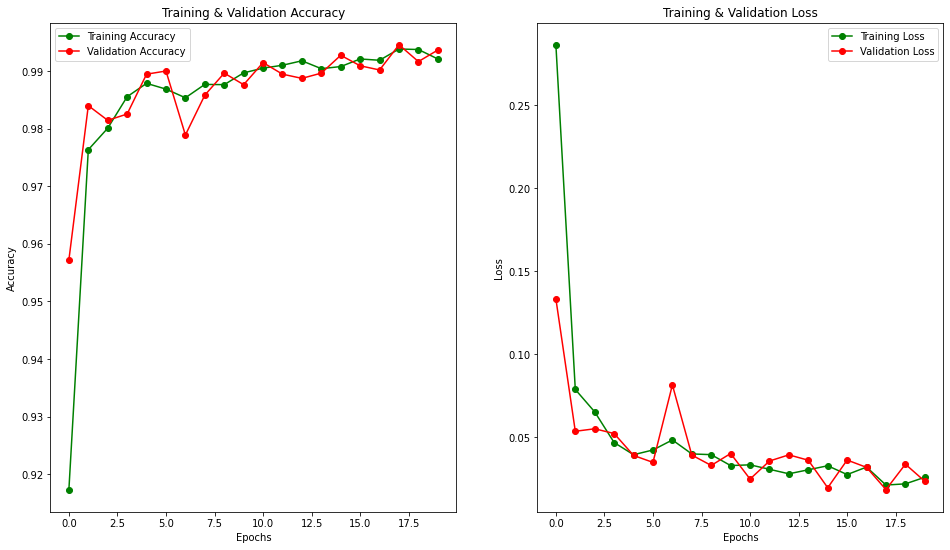

In [ ]:
plot_loss_accuracy(history)

In [13]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Kompjuterski vid/Projekat/Projekat_v4/Modeli_v4/model_mobilenet.hdf5')

In [17]:
model.evaluate(x_test,y_test)

225/225 [==============================] - 2s 10ms/step - loss: 0.0564 - accuracy: 0.9900 - f1_score: 0.9893 - precision: 0.9902 - recall: 0.9900


[0.056403327733278275,
 0.9899609684944153,
 array([1.        , 1.        , 1.        , 0.95669293, 0.9929221 ,
        1.        , 0.9704142 , 0.972973  , 0.9982669 , 0.9862595 ,
        0.9976134 , 0.99119496, 0.9982788 , 1.        , 1.        ,
        1.        , 0.9491525 , 0.9979716 , 0.9959514 , 0.94757277,
        0.9971014 , 1.        , 0.99072355, 1.        ], dtype=float32),
 0.9902371168136597,
 0.9899609684944153]

In [15]:
x_train = tf.keras.applications.mobilenet.preprocess_input(x_train)
model.evaluate(x_train,y_train)

858/858 [==============================] - 8s 9ms/step - loss: 0.0039 - accuracy: 0.9985 - f1_score: 0.9985 - precision: 0.9987 - recall: 0.9985


[0.003853845177218318,
 0.9985066652297974,
 array([1.        , 0.9960552 , 1.        , 0.9979141 , 1.        ,
        1.        , 0.99862194, 0.9980276 , 0.9995699 , 0.99458486,
        1.        , 0.99857885, 0.99782324, 1.        , 1.        ,
        1.        , 0.9922958 , 0.9983347 , 0.9995786 , 0.9943796 ,
        0.9990758 , 1.        , 1.        , 0.9995526 ], dtype=float32),
 0.9986521005630493,
 0.9984702467918396]

In [ ]:
predict_x= model.predict(x_test) 
predictions=np.argmax(predict_x,axis=1)
print(predictions)

225/225 [==============================] - 8s 33ms/step
[6 5 9 ... 2 4 2]


In [ ]:
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1

In [ ]:
print(classification_report(y,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       0.92      0.99      0.96       245
           4       1.00      0.99      0.99       498
           5       1.00      1.00      1.00       247
           6       1.00      0.94      0.97       348
           7       0.96      0.99      0.97       436
           8       1.00      1.00      1.00       288
          10       1.00      0.98      0.99       331
          11       1.00      1.00      1.00       209
          12       0.98      1.00      0.99       394
          13       1.00      1.00      1.00       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17       0.93      0.97      0.95       144
          18       1.00    

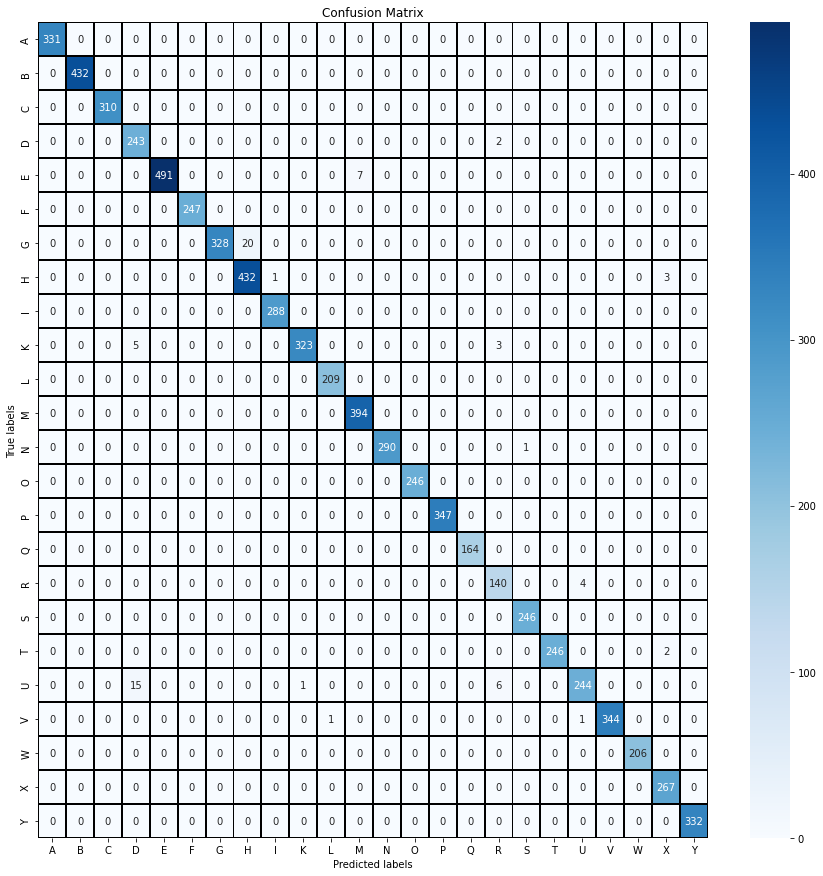

In [ ]:
cm = confusion_matrix(y,predictions)
cm = pd.DataFrame(cm, index = [i for i in range(25) if i!=9] , columns = [i for i in range(25) if i!=9])
plt.figure(figsize = (15,15))
ax= plt.subplot()
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labele); ax.yaxis.set_ticklabels(labele);